## Predicting Electricity Usage Based on Weather Conditions

Two datasets provided: 

- Weather: Weather data for one year with daily weather conditions
- Energy Usage: Energy usage history for one year (in kW) with 30-minute intervals. The energy usage of specific devices like AC, Fridge, washer, etc. are also given

### Part 1

Examine the data, parse the time fields wherever necessary. Take the sum of the energy usage (use [kW]) to get per day usage and merge it with weather data 

In [468]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings('ignore')

weather = pd.read_csv("weather_data.csv")
energy = pd.read_csv("energy_data.csv")

# Converting epoch time to date time
for i in range(len(weather['time'])):
    weather['time'][i] = datetime.datetime.fromtimestamp(weather['time'][i])

# Dropping non-numeric columns and weather date
weather.drop(weather.index[0:5], 0, inplace=True)
weather.drop(['icon', 'summary'], axis=1, inplace=True)
weather.reset_index(drop=True, inplace=True)
    
# Getting per day usage of energy, date, and all weather columns
time = []
use = []

counter = 0
for i in range(365):
    time.append(energy['Date & Time'][counter])
    use.append(energy['use [kW]'][counter: counter + 48].sum())
    counter += 48
    
counter = 0
for i in range(365):
    weather['time'][i] = weather['time'][counter]
    weather['temperature'][i] = weather['temperature'][counter: counter + 24].mean()
    weather['humidity'][i] = weather['humidity'][counter: counter + 24].mean()
    weather['visibility'][i] = weather['visibility'][counter: counter + 24].mean()
    weather['pressure'][i] = weather['pressure'][counter: counter + 24].mean()
    weather['windSpeed'][i] = weather['windSpeed'][counter: counter + 24].mean()
    weather['cloudCover'][i] = weather['cloudCover'][counter: counter + 24].mean()
    weather['windBearing'][i] = weather['windBearing'][counter: counter + 24].mean()
    weather['precipIntensity'][i] = weather['precipIntensity'][counter: counter + 24].mean()
    weather['dewPoint'][i] = weather['dewPoint'][counter: counter + 24].mean()
    weather['precipProbability'][i] = weather['precipProbability'][counter: counter + 24].mean()
    counter += 24
    

weather.drop(weather.index[365:], 0, inplace=True)
    
weather['energy_use (kW)'] = use

weather.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,energy_use (kW)
0,20.527917,0.552500,9.708750,1026.902083,6.412500,0.015217,2014-01-01 00:00:00,236,0.000000,6.619167,0.000000,65.013592
1,13.631250,0.811667,2.281667,1020.227917,9.620833,0.800000,2014-01-02 00:00:00,28,0.002688,8.934583,0.098333,32.305336
2,4.268333,0.653333,6.310417,1017.960833,10.912917,0.070000,2014-01-03 00:00:00,264,0.001346,-5.067083,0.056250,31.164468
3,6.788333,0.597500,9.836250,1029.377500,6.027500,0.001667,2014-01-04 00:00:00,218,0.000000,-5.176667,0.000000,45.287782
4,20.712083,0.761250,7.480833,1023.551250,2.481667,0.072353,2014-01-05 00:00:00,177,0.000721,14.093333,0.030833,36.316643


### Part 2

Extracting training and testing sets (should be predicting December)

In [469]:
# Splitting data into testing and training
train_x = weather.drop(['time','energy_use (kW)'], axis=1)[:334].to_numpy()
train_y = weather['energy_use (kW)'][:334].to_numpy()
test_x = weather.drop(['time','energy_use (kW)'], axis=1)[334:].to_numpy()
test_y = weather['energy_use (kW)'][334:].to_numpy()

### Part 3

Linear Regression - Predicting Energy Usage

In [470]:
from sklearn.linear_model import LinearRegression

# Modelling and predicting energy usage based on weather using Linear Regression
model = LinearRegression().fit(train_x, train_y)
predictedEnergy = model.predict(test_x)

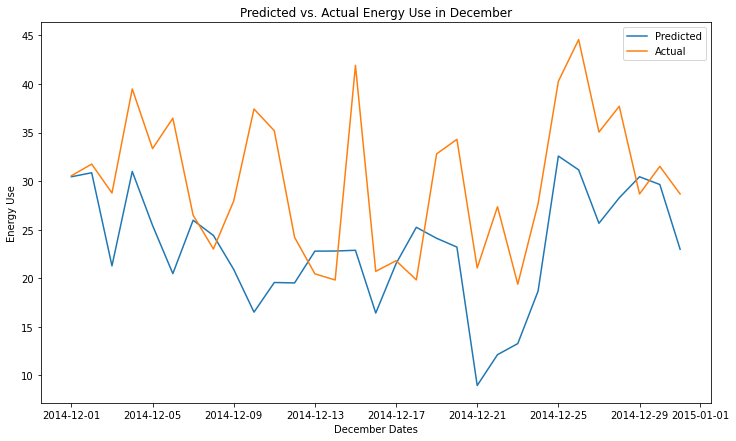

In [471]:
import matplotlib.pyplot as plt
%matplotlib inline

# Setting default plot sizes
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

# Plotting the predicted and actual values in December
plt.plot(weather['time'][334:], predictedEnergy, label="Predicted")
plt.plot(weather['time'][334:], test_y, label="Actual")
plt.xlabel("December Dates")
plt.ylabel("Energy Use")
plt.title("Predicted vs. Actual Energy Use in December")
plt.legend()

The model works relatively well. The predictions were on average slighly lower than the actual energy use, but the prediction was somewhat accurate especially between December 21st to the 25th with the upward trend in energy use.

In [472]:
from sklearn.metrics import mean_squared_error

# Getting the RMSE of predicted and actual values
rms = mean_squared_error(test_y, predictedEnergy, squared=False)
print("Root Mean Squared Error: " + str(rms))

Root Mean Squared Error: 9.464335455289048


Furthermore, the RMSE is relatively low, which means that the model fits relatively well.

Generating a csv dump of the predicted values

In [473]:
# Generating a csv dump of predicted values
df = pd.DataFrame({'date': weather['time'][334:],
                   'predicted': predictedEnergy})
df.to_csv('linear_regression.csv', index=False)

### Part 4

Logistic Regression - Temperature Classification

Using only weather data we want to classify if the temperature is high or low. Let's assume
temperature greater than or equal to 60 is ‘high’ and below 60 is ‘low’. Predict and classify temperatures in December.

In [474]:
# Making temperature bounds binary where high = 1 and low = 0
weather['temperature'] = weather['temperature'] >= 35
weather['temperature'] = weather['temperature'].astype(int)

# Setting training and testing sets again
train_x = weather.drop(['time','energy_use (kW)', 'temperature'], axis=1)[:334].to_numpy()
train_y = weather['temperature'][:334].to_numpy()
test_x = weather.drop(['time','energy_use (kW)', 'temperature'], axis=1)[334:].to_numpy()
test_y = weather['temperature'][334:].to_numpy()

from sklearn.linear_model import LogisticRegression

# Modelling and predicting temperature using Logistic Regression
reg_model = LogisticRegression(random_state=0).fit(train_x, train_y)
class_pred = reg_model.predict(test_x)

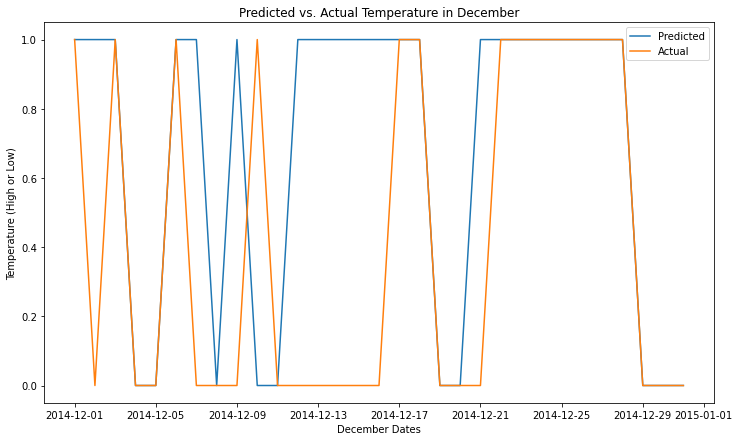

In [475]:
# Plotting the predicted and actual classifiers
plt.plot(weather['time'][334:], class_pred, label="Predicted")
plt.plot(weather['time'][334:], test_y, label="Actual")
plt.xlabel("December Dates")
plt.ylabel("Temperature (High or Low)")
plt.title("Predicted vs. Actual Temperature in December")
plt.legend()

In [476]:
from sklearn.metrics import f1_score

# Getting the F1 score of the predicted vs actual classifiers
score = f1_score(test_y, class_pred)

print("The F1 score for the classifier was: " + str(score))

The F1 score for the classifier was: 0.7058823529411765


The F1 score is relatively high at 0.7, meaning that the classifier was relatively accurate in predicting whether the temperature was high or low during December.

Generating a csv dump of the predicted values

In [477]:
# Generating a csv dump of predicted values
df = pd.DataFrame({'date': weather['time'][334:],
                   'predicted': class_pred})
df.to_csv('logistic_regression.csv', index=False)

### Part 5

Energy usage data analysis

For simplicity, let’s divide a day in two parts:
- Day : 6AM - 7PM
- Night: 7PM - 6AM

Will analyze fridge and microwave usage during January

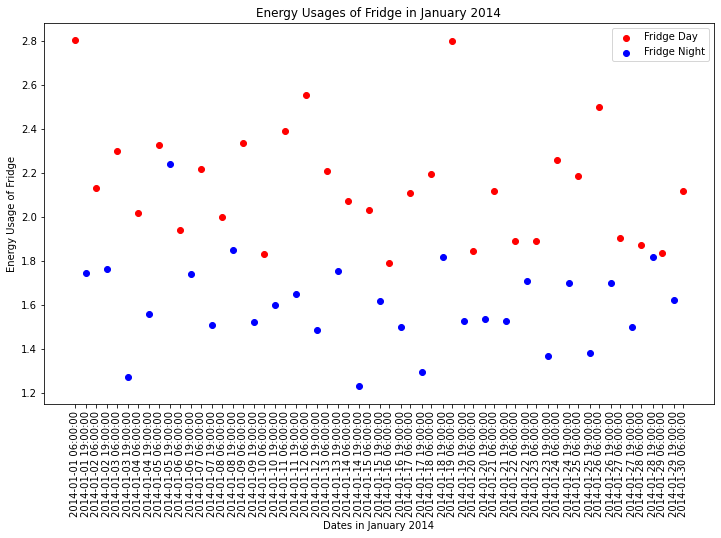

In [478]:
# Grabbing January dates in 2014
energy.drop(energy.index[0:12], 0, inplace=True)
energy.reset_index(drop=True, inplace=True)

# Getting energy usage per day as well as the time for day and night
timeDay = []
timeNight = []
microwaveDay = []
microwaveNight = []
fridgeDay = []
fridgeNight = []
actualTime = []

counter = 0
flag = False
for i in range(59):
    actualTime.append(energy['Date & Time'][counter])
    if flag == False:
        timeDay.append(energy['Date & Time'][counter])
        microwaveDay.append(energy['Microwave (R) [kW]'][counter: counter + 26].sum())
        fridgeDay.append(energy['Fridge (R) [kW]'][counter: counter + 26].sum())
        counter += 26
        flag = True
    else:
        timeNight.append(energy['Date & Time'][counter])
        microwaveNight.append(energy['Microwave (R) [kW]'][counter: counter + 22].sum())
        fridgeNight.append(energy['Fridge (R) [kW]'][counter: counter + 22].sum())
        counter += 22
        flag = False
        
import time

pattern = '%Y-%m-%d %H:%M:%S'

# Converting the time from date time back to epochs for plotting
for i in range(len(timeDay)):
    timeDay[i] = int(time.mktime(time.strptime(timeDay[i], pattern)))
for i in range(len(timeNight)):
    timeNight[i] = int(time.mktime(time.strptime(timeNight[i], pattern)))
    
timeEpoch = timeDay + timeNight
timeEpoch.sort()

# Plotting Energy Usages of the Fridge in January 2014
plt.scatter(timeDay, fridgeDay, label="Fridge Day", color='red')
plt.scatter(timeNight, fridgeNight, label="Fridge Night", color='blue')
temp = plt.xticks(timeEpoch, actualTime, rotation=90)
plt.xlabel("Dates in January 2014")
plt.ylabel("Energy Usage of Fridge")
plt.title("Energy Usages of Fridge in January 2014")
plt.legend()

This evidently shows that the fridge is used more often during the day than at night. This is obvious, as the fridge is used during the day to grab and store food, and thus uses more energy every time the fridge is opened and closed. However, there are occasions where the fridge energy used at night may exceed some days, and that could be due to midnight snacking or the fact that people are still consuming food after 7pm.

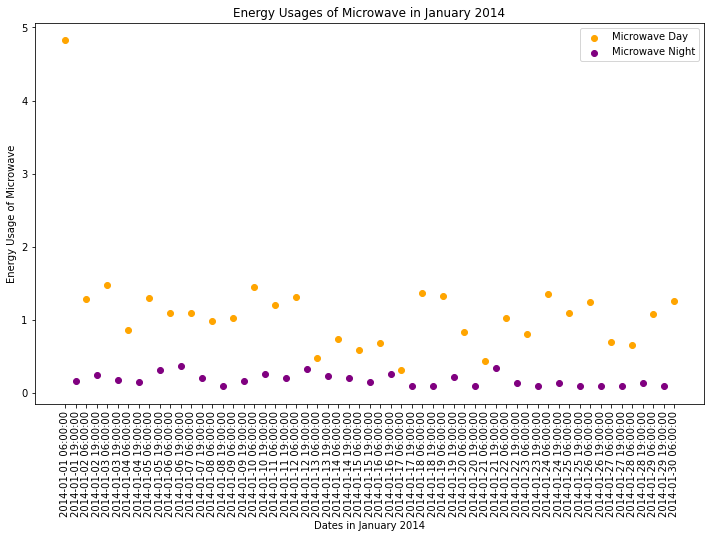

In [479]:
# Plotting Energy Usages of Microwave in January 2014
plt.scatter(timeDay, microwaveDay, label="Microwave Day", color='orange')
plt.scatter(timeNight, microwaveNight, label="Microwave Night", color='purple')
temp = plt.xticks(timeEpoch, actualTime, rotation=90)
plt.xlabel("Dates in January 2014")
plt.ylabel("Energy Usage of Microwave")
plt.title("Energy Usages of Microwave in January 2014")
plt.legend()

Similar to the fridge, the microwave is used much more often during the day. However, there is a larger discrepancy between energy usage during the day vs. energy usage during the night for the microwave because the microwave does not passively consume energy when it is not being used (as opposed to the fridge). Therefore, it is very rare to see microwave energy usage at night exceed that of the day.

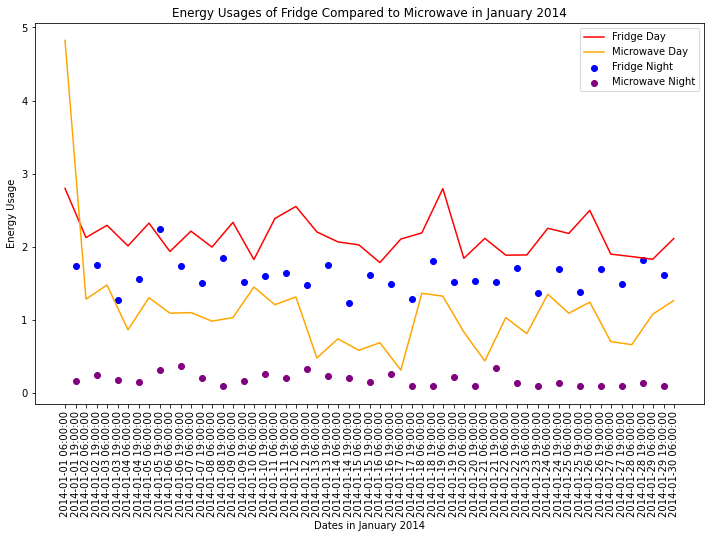

In [480]:
# Plotting Energy Usages of Fridge Compare to Microwave in January 2014
plt.plot(timeDay, fridgeDay, label="Fridge Day", color='red')
plt.scatter(timeNight, fridgeNight, label="Fridge Night", color='blue')
plt.plot(timeDay, microwaveDay, label="Microwave Day", color='orange')
plt.scatter(timeNight, microwaveNight, label="Microwave Night", color='purple')
temp = plt.xticks(timeEpoch, actualTime, rotation=90)
plt.xlabel("Dates in January 2014")
plt.ylabel("Energy Usage")
plt.title("Energy Usages of Fridge Compared to Microwave in January 2014")
plt.legend()

When comparing the usages of the fridge against the usages of the microwave, it shows that the microwave pattern during the day follows the fridge pattern during the day pretty closely. This could show a trend that food typically taken out of the fridge is microwaved. 

### Conclusions

Through modelling, predictions, and analysis, a lot of data was uncovered about energy usage and weather patterns. Perhaps this data could be extrapolated for further use in the future.

Horace Liu